# 0-π oscillations in altermagnetic Josephson junctions

## Common imports


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

from bodge import *


Bad key "text.kerning_factor" on line 4 in
/opt/intel/oneapi/intelpython/latest/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Lattice construction
These functions take lattice coordinates $i, j ∈ \mathbb{N}^3$ as inputs, and for a given junction type (0º or 45º interfaces) determines whether a region is superconducting, normal metallic, or altermagnetic. Note that these functions depend on some global variables like `DIAG` and `L_SC`, which are used to alter the properties of the junctions investigated below. These variables are declared here but updated below.

In [2]:
# Whether the system has a diagonal interface.
DIAG = False

# Dimensions of the cubic lattice.
L_X = 0
L_Y = 0
L_Z = 0

# Superconductor length.
L_SC = 0 

# Normal-metal spacer length.
L_NM = 0

# Interlayer length. This can be an altermagnet.
L_IL = 0

This function calculates an "equivalent x-coordinate" for junctions with diagonal interfaces, defined as the x-coordinate at the center along the y-axis.

In [3]:
def diax(i):
    return i[0] + (i[1] - L_Y//2) * DIAG

These functions check whether a coordinate is superconducting, normal metallic, or altermagnetic.

In [4]:
def SC1(i):
    return diax(i) < L_SC
    
def SC2(i):
    return diax(i) >= L_X - L_SC

def NM1(i):
    return diax(i) < L_SC + L_NM and not SC1(i)

def NM2(i):
    return diax(i) >= L_X - L_SC - L_NM and not SC2(i)

def IL(i):
    return not SC1(i) and not SC2(i) and not NM1(i) and not NM2(i)

These functions let us calculate the y-integrated current in the middle of the first normal-metal layer, which we will use as a measure for the supercurrent. We calculate the current at $T = 0.01t$ for now.

In [5]:
def probe(i):
    return diax(i) == L_SC + L_NM//2

def current(system, N=600):
    F = FermiMatrix(system, N)(0.01)
    Jx = F.current_elec(axis=0)
    Jy = F.current_elec(axis=1)

    J = 0.0
    for i in lattice.sites():
        if probe(i):
            if DIAG:
                # Current in 45º direction.
                J += (Jx[i] + Jy[i])/np.sqrt(2)
            else:
                # Current in 0º direction.
                J += Jx[i]

    return J

We can also define a function for visualizing the lattices, to reduce the chance of errors. The evaluation point for currents is plotted in red.

In [6]:
def show():
    lattice = CubicLattice((L_X, L_Y, L_Z))

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_axis_off()

    for i in lattice.sites():
        if SC1(i) or SC2(i):
            ax.scatter(x=i[0], y=i[1], color='#ff7f00')
        if NM1(i) or NM2(i):
            ax.scatter(x=i[0], y=i[1], color='k')
        if IL(i):
            ax.scatter(x=i[0], y=i[1], color='#984ea3')
        if probe(i):
            ax.scatter(x=i[0], y=i[1], color='#ff0000')

    plt.show()

Let's test that these work as expected by plotting one diagonal and one non-diagonal lattice.

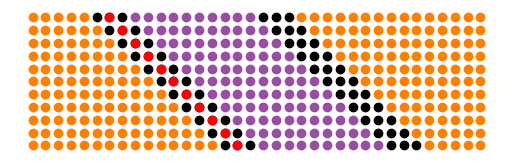

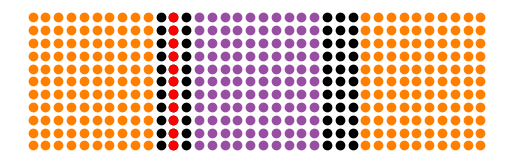

In [7]:
L_SC = 10 
L_NM = 3
L_IL = 10

L_X = 2 * L_SC + 2 * L_NM + L_IL
L_Y = 11
L_Z = 1

DIAG = True

show()

DIAG = False

show()

## Normal-metal baseline


For comparison to the altermagnetic case, let's do a quick run on normal metals (which have no 0-π oscillations). Based on separate benchmarks of the Chebyshev code, we should use 600 polynomials at least for explorative current calculations and perhaps 2000 for final ones.

First, let's define the tight-binding parameters:

In [8]:
t = 1.0
μ = -t/2
Δ0 = -t
δφ = π/2

  0%|          | 0/15 [00:00<?, ?it/s]

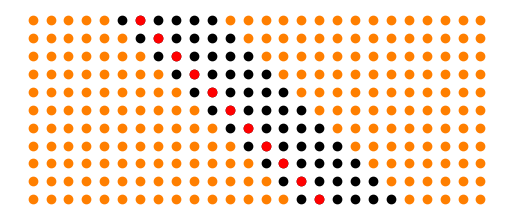

  7%|▋         | 1/15 [00:03<00:55,  3.98s/it]

	J/t = 4.202698778997574


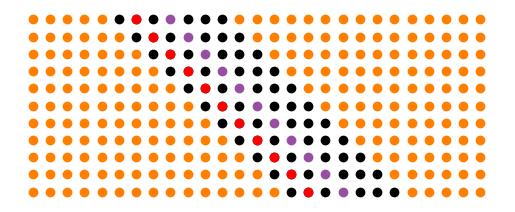

 13%|█▎        | 2/15 [00:08<00:53,  4.15s/it]

	J/t = 3.4548206594483726


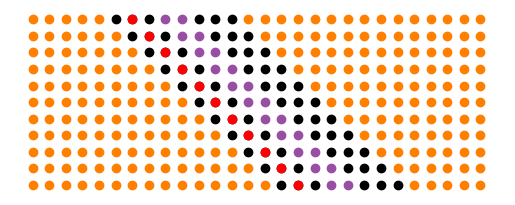

 20%|██        | 3/15 [00:12<00:52,  4.37s/it]

	J/t = 3.2600282608025495


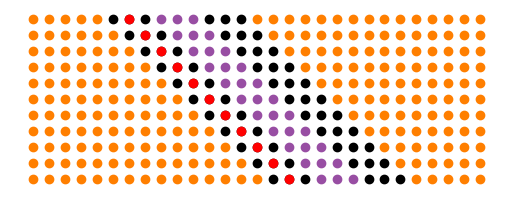

 27%|██▋       | 4/15 [00:17<00:50,  4.55s/it]

	J/t = 2.6936286599058117


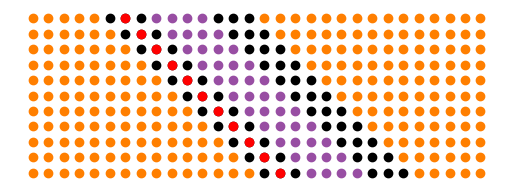

 33%|███▎      | 5/15 [00:22<00:48,  4.81s/it]

	J/t = 2.5708390739569276


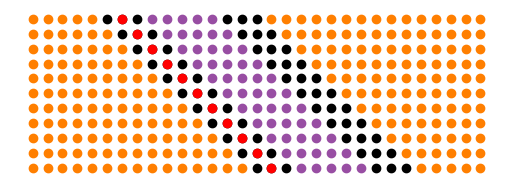

 40%|████      | 6/15 [00:28<00:45,  5.01s/it]

	J/t = 2.177927350099716


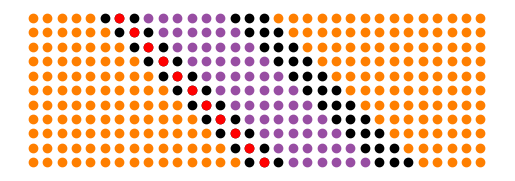

 47%|████▋     | 7/15 [00:34<00:42,  5.26s/it]

	J/t = 2.06227663526919


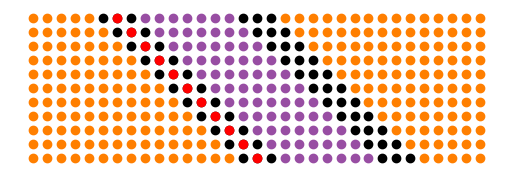

 53%|█████▎    | 8/15 [00:40<00:38,  5.53s/it]

	J/t = 1.7920600483358151


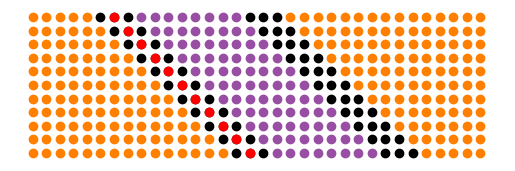

 60%|██████    | 9/15 [00:46<00:34,  5.81s/it]

	J/t = 1.6751578460100163


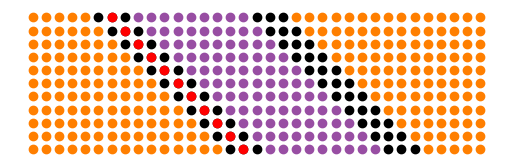

 67%|██████▋   | 10/15 [00:53<00:30,  6.11s/it]

	J/t = 1.5002574582728043


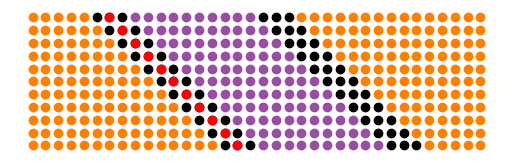

 73%|███████▎  | 11/15 [01:00<00:25,  6.45s/it]

	J/t = 1.3820269615436889


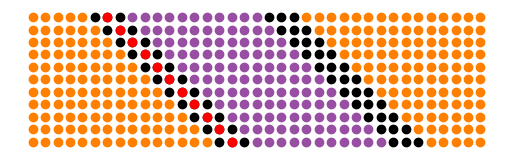

 80%|████████  | 12/15 [01:08<00:20,  6.77s/it]

	J/t = 1.2772961537011183


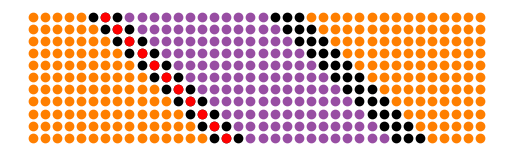

 80%|████████  | 12/15 [01:13<00:18,  6.10s/it]


KeyboardInterrupt: 

In [9]:
LL = []
JJ = []

for DIAG in [True, False]:
    Ls = []
    Js = []

    for L_IL in trange(15):
        L_Y = 11
        L_X = 2 * L_SC + 2 * L_NM + L_IL
        show()

        lattice = CubicLattice((L_X, L_Y, L_Z))
        system = Hamiltonian(lattice)

        with system as (H, Δ, V):
            for i in lattice.sites():
                H[i, i] = -μ * σ0
                if SC1(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
                if SC2(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)
            for i, j in lattice.bonds():
                H[i, j] = -t * σ0
        
        Js.append(current(system))
        Ls.append(L_IL)

        print(f"\tJ/t = {Js[-1]}")

    LL.append(Ls)
    JJ.append(Js)

plt.plot(LL[0], JJ[0], "r", LL[1], JJ[1], "b")
plt.xlabel("Interlayer length $L_{IL}/a$")
plt.ylabel("Supercurrent $I/t$")
plt.show()

This shows a qualitatively similar behavior for S/N/S junctions with the two different types of interfaces, although the curves quantitatively differ by perhaps 10% or so.

## Ferromagnetic baseline

Let's now try to use a ferromagnetic interlayer and repeat the experiment above. The point is to show that we can get 0-π oscillations for both types of interfaces, as a comparison for the altermagnets.

In [10]:
m = 3 * t / 2

  0%|          | 0/19 [00:00<?, ?it/s]

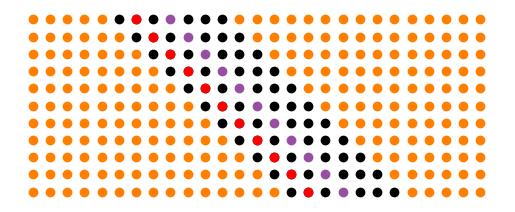

  5%|▌         | 1/19 [00:04<01:19,  4.40s/it]

	J/t = 2.854504664059803


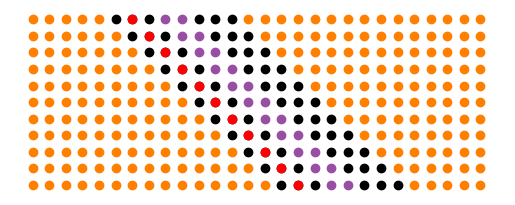

 11%|█         | 2/19 [00:08<01:16,  4.51s/it]

	J/t = -0.6857515459102708


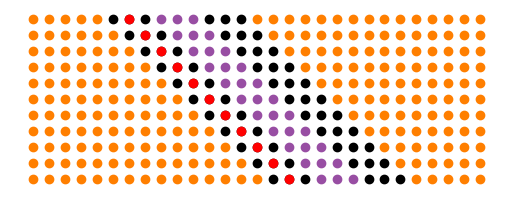

 16%|█▌        | 3/19 [00:13<01:14,  4.67s/it]

	J/t = -2.3047684930509162


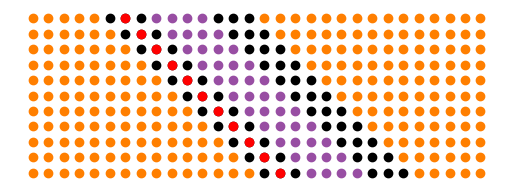

 21%|██        | 4/19 [00:19<01:13,  4.90s/it]

	J/t = -1.5317545252530458


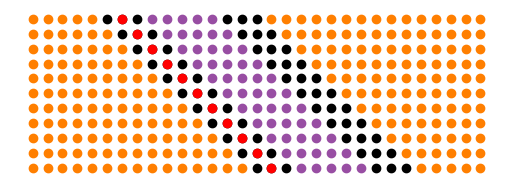

 26%|██▋       | 5/19 [00:24<01:11,  5.11s/it]

	J/t = -0.7245022120319213


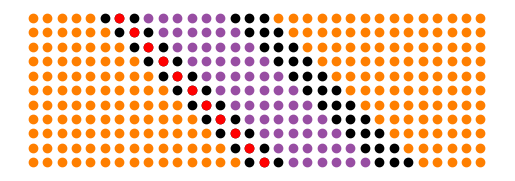

 32%|███▏      | 6/19 [00:30<01:09,  5.37s/it]

	J/t = 0.4208673088191589


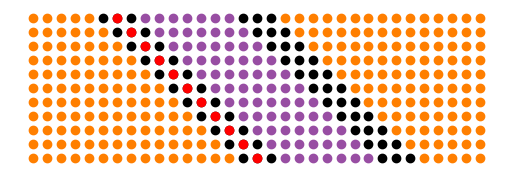

 37%|███▋      | 7/19 [00:36<01:07,  5.63s/it]

	J/t = 1.035010467117132


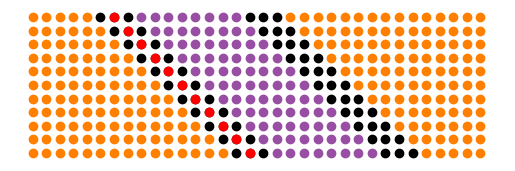

 42%|████▏     | 8/19 [00:43<01:04,  5.89s/it]

	J/t = 0.7972237938578415


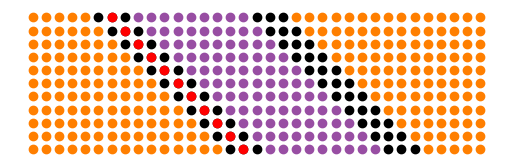

 47%|████▋     | 9/19 [00:49<01:01,  6.19s/it]

	J/t = 0.2901086536507275


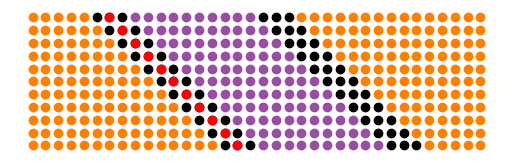

 53%|█████▎    | 10/19 [00:57<00:58,  6.48s/it]

	J/t = -0.3233953543476659


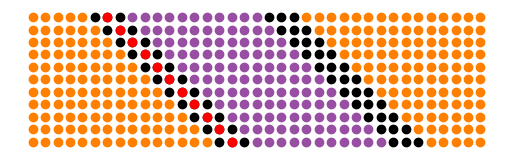

 58%|█████▊    | 11/19 [01:04<00:54,  6.80s/it]

	J/t = -0.5814817939252293


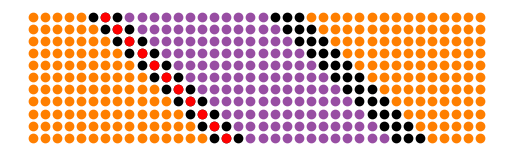

 58%|█████▊    | 11/19 [01:07<00:49,  6.16s/it]


KeyboardInterrupt: 

In [11]:
LL = []
JJ = []

for DIAG in [True, False]:
    Ls = []
    Js = []

    for L_IL in trange(1, 20):
        L_Y = 11
        L_X = 2 * L_SC + 2 * L_NM + L_IL
        show()

        lattice = CubicLattice((L_X, L_Y, L_Z))
        system = Hamiltonian(lattice)

        with system as (H, Δ, V):
            for i in lattice.sites():
                if IL(i):
                    H[i, i] = -μ * σ0 - m * σ3
                else:
                    H[i, i] = -μ * σ0

                if SC1(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
                if SC2(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)
            for i, j in lattice.bonds():
                H[i, j] = -t * σ0
        
        Js.append(current(system))
        Ls.append(L_IL)

        print(f"\tJ/t = {Js[-1]}")

    LL.append(Ls)
    JJ.append(Js)

plt.plot(LL[0], JJ[0], "r", LL[1], JJ[1], "b")
plt.xlabel("Interlayer length $L_{IL}/a$")
plt.ylabel("Supercurrent $I/t$")
plt.show()

Clearly, the interface type changes the period drastically, but 0-π oscillations occurs for both.

## Altermagnetic test for δφ = π/2


  0%|          | 0/19 [00:00<?, ?it/s]

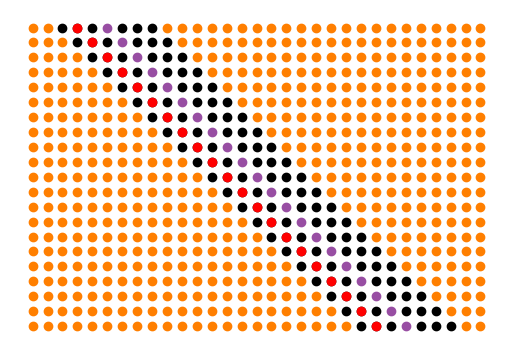

  5%|▌         | 1/19 [00:17<05:20, 17.82s/it]

	J/t = 7.281984602396355


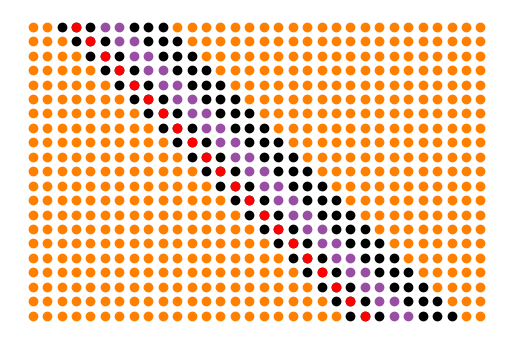

 11%|█         | 2/19 [00:36<05:15, 18.58s/it]

	J/t = 2.658211179507482


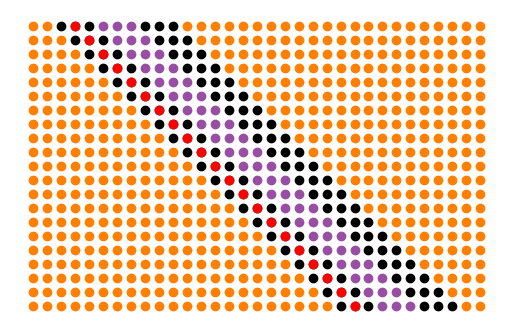

 16%|█▌        | 3/19 [00:56<05:08, 19.26s/it]

	J/t = -1.8232662902564316


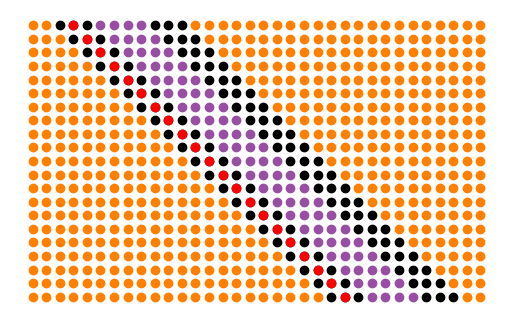

 16%|█▌        | 3/19 [01:01<05:27, 20.45s/it]


KeyboardInterrupt: 

In [13]:
m = 1.5 * t
L_Y = 21
L_SC = 12

LL = []
JJ = []

for DIAG in [True, False]:
    Ls = []
    Js = []

    for L_IL in trange(1, 20):
        L_X = 2 * L_SC + 2 * L_NM + L_IL
        show()

        lattice = CubicLattice((L_X, L_Y, L_Z))
        system = Hamiltonian(lattice)

        with system as (H, Δ, V):
            for i in lattice.sites():
                H[i, i] = -μ * σ0

                if SC1(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
                if SC2(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)

            for i, j in lattice.bonds(axis=0):
                if IL(i) and IL(j):
                    H[i, j] = -t * σ0 - m * σ3
                else:
                    H[i, j] = -t * σ0

            for i, j in lattice.bonds(axis=1):
                if IL(i) and IL(j):
                    H[i, j] = -t * σ0 + m * σ3
                else:
                    H[i, j] = -t * σ0
    
        Js.append(current(system))
        Ls.append(L_IL)

        print(f"\tJ/t = {Js[-1]}")

    LL.append(Ls)
    JJ.append(Js)

plt.plot(LL[0], JJ[0], "r", LL[1], JJ[1], "b")
plt.xlabel("Interlayer length $L_{IL}/a$")
plt.ylabel("Supercurrent $I/t$")
plt.show()

**Conclusion:** Diagonal interface alone is insufficient to prevent 0-π oscillations inside of altermagnets. It appears we need to make the whole junction diagonal to prevent them from appearing.

## Lattice construction revised
Let's now revise the lattice construction to make perfectly diagonal junctions. First, we define functions `x` and `y` to generate the junction coordinates that correspond to a provided lattice coordinate `i`.

In [14]:

def x(i):
    if not DIAG:
        return i[0]
    else:
        return (i[0] + (L_X - i[1]))//2

def y(i):
    if not DIAG:
        return i[1]
    else:
        return (i[0] - (L_X - i[1]))//2


We also need a safeguard function to check if a coordinate is in the junction.

In [15]:
def inside(i):
    return x(i) >= 0 and x(i) < L_X and y(i) >= 0 and y(i) < L_Y

Now, we revise the functions used to define the junction we considered before.

In [16]:
def SC1(i):
    return inside(i) and x(i) < L_SC
    
def SC2(i):
    return inside(i) and x(i) >= L_X - L_SC

def NM1(i):
    return inside(i) and x(i) < L_SC + L_NM and not SC1(i)

def NM2(i):
    return inside(i) and x(i) >= L_X - L_SC - L_NM and not SC2(i)

def IL(i):
    return inside(i) and not SC1(i) and not SC2(i) and not NM1(i) and not NM2(i)

In [17]:
def probe(i):
    return inside(i) and x(i) == L_SC + L_NM//2

In [18]:
def create():
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_axis_off()
    marker="."

    if DIAG:
        sidelength = L_X + L_Y
        lattice = CubicLattice((sidelength, sidelength, 1))
    else:
        lattice = CubicLattice((L_X, L_Y, 1))

    NS = 0
    NP = 0
    for i in lattice.sites():
        if probe(i):
            ax.scatter(x=i[0], y=i[1], color='#ff0000', marker=marker)
            NP += 1
        elif SC1(i) or SC2(i):
            NS += 1
            ax.scatter(x=i[0], y=i[1], color='#ff7f00', marker=marker)
        elif NM1(i) or NM2(i):
            ax.scatter(x=i[0], y=i[1], color='k', marker=marker)
        elif IL(i):
            ax.scatter(x=i[0], y=i[1], color='#984ea3', marker=marker)
        else:
            ax.scatter(x=i[0], y=i[1], color='#eeeeee', marker=marker)
    print(NS, NP)

    plt.show()

    return lattice

484 22


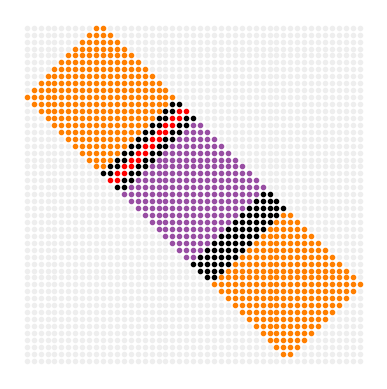

448 16


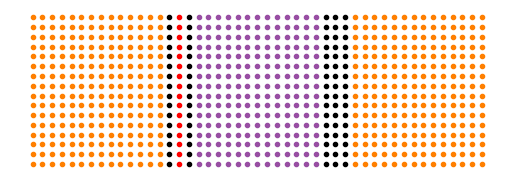

In [19]:
L_SC = 11 
L_NM = 3
L_IL = 10

L_X = 2 * L_SC + 2 * L_NM + L_IL
L_Y = 11
L_Z = 1

DIAG = True

lattice = create()

DIAG = False

L_SC = int(1.33 * L_SC)
L_NM = int(1.33 * L_NM)
L_IL = int(1.33 * L_IL)
L_Y = int(1.5 * L_Y)

L_X = 2 * L_SC + 2 * L_NM + L_IL

lattice = create()

## New altermagnets

In [20]:
def current(system, N=600):
    F = FermiMatrix(system, N)(0.01)
    Jx = F.current_elec(axis=0)
    Jy = F.current_elec(axis=1)

    J = 0.0
    for i in lattice.sites():
        if inside(i):
            if probe(i):
                if DIAG:
                    # Current in 45º direction.
                    J += (Jx[i] - Jy[i])/np.sqrt(2)
                else:
                    # Current in 0º direction.
                    J += Jx[i]

    return J

  0%|          | 0/19 [00:00<?, ?it/s]

484 22


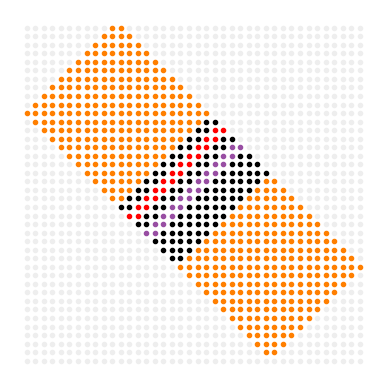

  5%|▌         | 1/19 [00:19<05:49, 19.39s/it]

	J/t = 1.3712821611539416
484 22


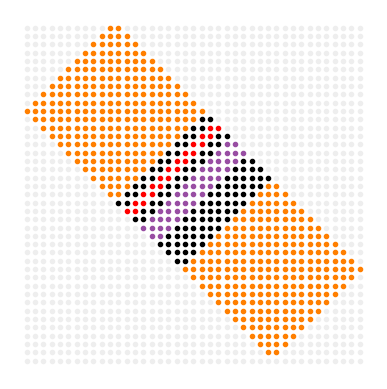

In [21]:
t = 1.0
Δ0 = -t
μ = -t/2
m = 1.5 * t
δφ = π/2

L_SC = 11 
L_NM = 3
L_IL = 10
L_Y = 11
L_Z = 1

DIAG = True

LL = []
JJ = []

Ls = []
Js = []

for L_IL in trange(1, 20):
    L_X = 2 * L_SC + 2 * L_NM + L_IL
    lattice = create()
    system = Hamiltonian(lattice)

    with system as (H, Δ, V):
        for i in lattice.sites():
            if inside(i):
                H[i, i] = -μ * σ0
            if SC1(i):
                Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
            if SC2(i):
                Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)

        for i, j in lattice.bonds(axis=0):
            if IL(i) and IL(j):
                H[i, j] = -t * σ0 - m * σ3
            elif inside(i) and inside(j):
                H[i, j] = -t * σ0

        for i, j in lattice.bonds(axis=1):
            if IL(i) and IL(j):
                H[i, j] = -t * σ0 + m * σ3
            elif inside(i) and inside(j):
                H[i, j] = -t * σ0

    Js.append(current(system))
    Ls.append(L_IL)

    print(f"\tJ/t = {Js[-1]}")

# LL.append(Ls)
# JJ.append(Js)

# plt.plot(LL[0], JJ[0], "r", LL[1], JJ[1], "b")
# plt.xlabel("Interlayer length $L_{IL}/a$")
# plt.ylabel("Supercurrent $I/t$")
# plt.show()